In [1]:
%load_ext autoreload
%autoreload 10

In [14]:
import cv2
import dlib
import imutils
from imutils import face_utils
import numpy as np

from tqdm import tqdm

In [6]:
!pip3 install dlib

     |████████████████████████████████| 3.2 MB 6.6 MB/s eta 0:00:01
  Created wheel for dlib: filename=dlib-19.19.0-cp36-cp36m-linux_x86_64.whl size=3952799 sha256=6708a9594e1f45f8b87b011ba37133dfaf784caaf10e064081cf4e7cf400eb11
  Stored in directory: /home/students/student3_17/.cache/pip/wheels/ff/84/31/bf84ac0e80b4b05cc049f821e3db11dc2e6331bd4a4916dab4
Successfully built dlib


In [5]:
import os
import sys
import glob

sys.path.append("../")

In [3]:
IMAGETYPES = ('*.bmp', '*.png', '*.jpg', '*.jpeg', '*.tif') # Supported image types


def get_image_paths(file_root, pattern=None):
    """ Get ordered list of filepaths
    """
    file_paths = []
    for typ in IMAGETYPES:
        file_paths.extend(glob.glob(os.path.join(file_root,'**',typ), recursive=True))

    # filter filenames
    if pattern is not None:
        ffiltered = []
        ffiltered = [f for f in file_paths if pattern in os.path.split(f)[-1]]
        file_paths = ffiltered
        del ffiltered

    file_paths.sort()
    return file_paths


def load_face_dataset(file_root):
    """ Load all images and also list out the filepaths
    """
    if not os.path.isdir(file_root):
        raise FileNotFoundError("Face dataset file root: {} not found.".format(file_root))

    file_paths = get_image_paths(file_root)
    
    if len(file_paths) == 0:
        warnings.warn("No image found in face dataset file root: {}".format(file_root))
        return []
    
    images = [cv2.imread(file_path) for file_path in file_paths]
    return images, file_paths

In [4]:
def _crop_from_rect(image, rect):
    # single face mode where only one rectangle per image
    # rectangle here denote bounding box of a face in an image
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    face = image[y:y+h, x:x+w, :]
    return face

def _crop_from_rects(image, rects):
    # multi face mode where one image map to many rectangles
    # rectangle here denote bounding box of a face in an image
    faces = []
    for rect in rects:
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = image[y:y+h, x:x+w, :]
        faces.append(face)
    return faces

In [8]:
imageMean = [104.0, 177.0, 123.0]
confThresh = 0.5


class FaceHaarDetectCrop(object):
    """ Face detector that detect faces in an image and yield cropped faces image
    """

    def __init__(self, prototxt, caffeModel, imsize=(300,300), 
                 multiFaceMode=False, strict=False):
        """ Initialise face detector

        Args:
            .. prototxt   (str/path): path to prototxt file defining the architecture
            .. caffeModel (str/path): path to checkpoint file of pretrained caffe model
            .. imsize   (Tuple[int]): height and width of image blob
            .. multiFaceMode  (bool): whether to detect only multiple or single face for each image
            .. strict (bool) : if no face detected, raise error
        """
        if not os.path.isfile(prototxt):
            raise FileNotFoundError("Prototxt file: {} not found.".format(prototxt))
        
        if not os.path.isfile(caffeModel):
            raise FileNotFoundError("CaffeModel file: {} not found.".format(caffeModel))

        self.imsize = imsize
        self.multiFaceMode = multiFaceMode
        self.detector = cv2.dnn.readNetFromCaffe(prototxt, caffeModel=caffeModel)

    def _detect_single_face(self, image):
        """ Apply detection assuming only one face per image
        
        Args:
            .. image (np.ndarray): images in numpy tensor form of shape [C,H,W]
        
        Returns:
            .. face (np.ndarray or None): image in numpy tensor of shape [C,H,W]. None if no face
        """
        h, w = image.shape[:2]

        # construct a blob from the image
        imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, self.imsize), 1.0, self.imsize, imageMean)

        # apply OpenCV's deep learning-based face detector to localize
        # faces in the input image
        self.detector.setInput(imageBlob)
        detections = self.detector.forward()
        
        # ensure at least one face was found
        if len(detections) > 0:
            # we're making the assumption that each image has only ONE
            # face, so find the bounding box with the largest probability
            i = np.argmax(detections[0, 0, :, 2])
            confidence = detections[0, 0, i, 2]

            # filter out weak detections
            if confidence > confThresh:
                # compute the (x, y)-coordinates of the bounding box for
                # the face
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # grab the ROI dimensions
                (fH, fW) = endY - startY, endX - startX

                # ensure the face width and height are sufficiently large
                if fW > 40 and fH > 40:
                    rect = dlib.rectangle(startX, startY, startX+fW, startY+fH)
                    return rect

        if strict:
            raise ValueError("Unable to detect face during FaceDetection in one of the image passed.\n"
                             "Ensure that image is clean and has face in it. "
                             "You can also \n increase the threshold.")
        return None
    
    def _detect_multi_faces(self, image):
        """ Apply detection assuming only one face per image
        
        Args:
            .. image (np.ndarray): images in numpy tensor form of shape [C,H,W]
        
        Returns:
            .. face_images (np.ndarray or None): array of faces images of shape 
        """
        blob = cv2.dnn.blobFromImage(cv2.resize(image, self.imsize, 1.0, self.imsize, imageMean))

        # apply OpenCV's deep learning-based face detector to localize
        # faces in the input image
        self.detector.setInput(imageBlob)
        detections = self.detector.forward()

        rects = []
        
        # loop over the detections
        for i in range(0, detections.shape[2]):
            # extract the confidence (i.e., probability) associated with
            # the prediction
            confidence = detections[0, 0, i, 2]

            # filter out weak detections with less than 50% confidence
            if confidence > 0.5:
                # compute the (x, y)-coordinates of the bounding box for
                # the face
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                # grab the ROI dimensions
                (fH, fW) = endY - startY, endX - startX

                # ensure the face width and height are sufficiently large
                if fW < 40 or fH < 40:
                    continue

                rect = dlib.rectangle(startX, startY, startX+fW, startY+fH)
                rects.append(rect)

        return rects

    def __call__(self, images):
        """ Perform face detection and cropping for batch of images
        
        Args:
            .. images (np.ndarray): array of images in tensor form of shape [C,H,W]

        Returns:
            .. faces (np.ndarray or List[List[np.ndarray]]): array of images in numpy tensor.
                    If multiFaceMode false, output is tensor of shape: [N,C,H,W]
                    If multiFaceMode true, output is array of cropped faces.
        """
        for image in tqdm(images):
            if self.multiFaceMode == True:
                rects = self._detect_multi_faces(image)
                yield rects
            
            else:
                rect = self._detect_single_face(image)
                yield rect

In [122]:
data_dir = "../data/temp2/billy"

images, file_paths = load_face_dataset(data_dir)

### Simple Pipeline 

In [11]:
# define file paths to model files
prototxt = '../models/deploy.prototxt'
caffeModel = '../models/res10_300x300_ssd_iter_140000.caffemodel'

In [12]:
detect_crop = FaceHaarDetectCrop(prototxt, caffeModel, imsize=(300,300), multiFaceMode=False)

In [ ]:
rects = detect_crop(images)
faces = [_crop_from_rect(image, rect) for (image, rect) in zip(images, rects)]

In [27]:
faces = [_crop_from_rect(image, rect) for (rect, image) in zip(detect_crop(images), images)]


100%|██████████| 70/70 [00:02<00:00, 32.29it/s]


In [29]:
def rename_file_with_expression(filename):
    return filename.split('_')[-1]

In [105]:
# save cropped face images to ../data/processed/cropped/
cropped_dir = '../data/processed/cropped/'

for face, file_path in zip(faces, file_paths):
    foldername = os.path.basename(os.path.dirname(file_path))
    filename = os.path.basename(file_path) # rename_file_with_expression(file_path)
    
    os.makedirs(os.path.join(cropped_dir, foldername), exist_ok=True)
    save_path = os.path.join(cropped_dir, foldername, filename)
    success = cv2.imwrite(save_path, face)
    if not success:
        print("Unsuccessful when saving image {} to {}".format(face.shape, save_path))

In [116]:
# define file path to model files
faceLandmarkModel = "../models/shape_predictor_5_face_landmarks.dat"
predictor = dlib.shape_predictor(faceLandmarkModel)

desired_left_eye = (0.21, 0.21)
desired_face_width, desired_face_height = 300, 300

def _align_face(image, rect):
    """ Rotate and affine transformation to align face in the image to 0 degree.
    Args:
        .. image (np.ndarray): image face of shape [H,W,C]
        .. rect (dlib.rectangles): rect bounding box representation
    """

    # predict 68 facial landmarks coordinates and
    # convert the landmark (x, y) ~ coordinates to numpy array
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # compute the center of mass for each eye
    left_eye_center = (shape[0] + shape[1]) / 2.0
    right_eye_center = (shape[2] + shape[3]) / 2.0

    # and compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dy, dx)) - 180

    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desired_right_eye_x = 1.0 - desired_left_eye[0]

    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dx ** 2) + (dy ** 2))
    desired_dist = (desired_right_eye_x - desired_left_eye[0])
    desired_dist *= desired_face_width
    scale = desired_dist / dist

    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyes_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                   (right_eye_center[1] + right_eye_center[1]) // 2)

    # grab the rotation matrix for rotating and scaling the face
    rot_mat = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    tx = desired_face_width * 0.5
    ty = desired_face_height * desired_left_eye[1]

    rot_mat[0, 2] += (tx - eyes_center[0])
    rot_mat[1, 2] += (ty - eyes_center[1])

    # apply the affine transformation
    (w, h) = (desired_face_width, desired_face_height)
    face = cv2.warpAffine(image, rot_mat, (w, h), flags=cv2.INTER_CUBIC)

    return face

In [73]:
desired_left_eye = (0.24, 0.24)

In [123]:
rects = detect_crop(images)

In [ ]:
faces_aligned = [_align_face(image, rect) for image, rect in zip(images, rects)]

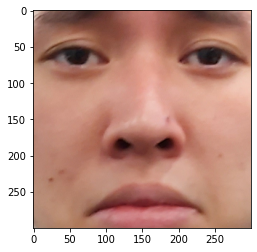

In [125]:
plt.imshow(faces_aligned[1][:,:,::-1]);

In [126]:
# save cropped face images to ../data/processed/cropped/
cropped_dir = '../data/processed/cropped/'

for face, file_path in zip(faces_aligned, file_paths):
    foldername = os.path.basename(os.path.dirname(file_path))
    filename = os.path.basename(file_path) # rename_file_with_expression(file_path)
    
    os.makedirs(os.path.join(cropped_dir, foldername), exist_ok=True)
    save_path = os.path.join(cropped_dir, foldername, filename)
    success = cv2.imwrite(save_path, face)
    if not success:
        print("Unsuccessful when saving image {} to {}".format(face.shape, save_path))

In [79]:
# irfan rotated
irfan = cv2.imread("irfan_smile_.jpg")

In [93]:
rects = detect_crop([irfan])

In [ ]:
irvan = [_align_face(image, rect) for image, rect in zip([irfan], rects)]

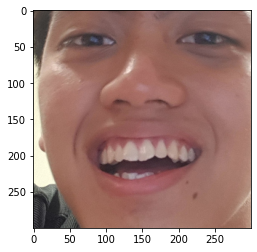

In [127]:
plt.imshow(irvan[0][:,:,::-1])